In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from scipy.stats import randint as sp_randInt
from scipy.stats import uniform as sp_randFloat
import optuna

import sklearn
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, \
HistGradientBoostingClassifier
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from xgboost import XGBClassifier


import plotly.express as px
import pickle
import warnings
warnings.filterwarnings('ignore')


## Import and arrange the data 

In [2]:
my_data = pickle.load(open('data/ass2.pickle', 'rb'))
X_train, y_train = my_data['train']
X_test,y_test  = my_data['dev']
df = X_train
df = df.assign(target = y_train)
test = X_test.assign(target = y_test)
X = pd.concat([X_train, X_test])
y=pd.concat([y_train, y_test])

## Preliminary data analysis

Text(0.5, 1.0, 'Test Classes')

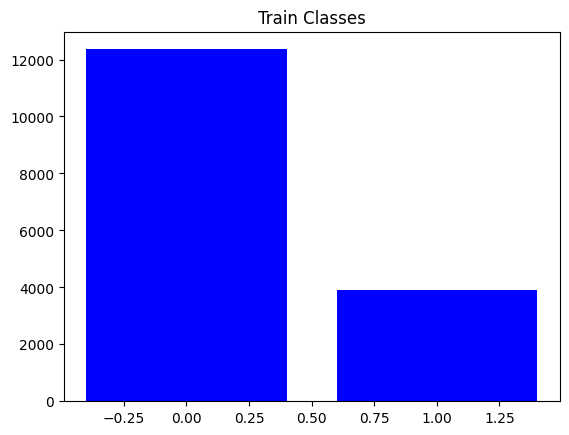

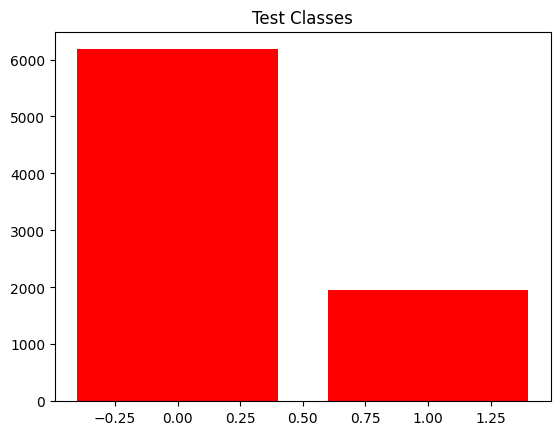

In [3]:
fig, ax = plt.subplots()
x = [0,1]
nums = [sum(df['target']==0), sum(df['target']==1)]
ax.bar(x,nums,color =['blue', 'blue'])
ax.set_title('Train Classes')
fig, ax = plt.subplots()
x = [0,1]
nums = [sum(test['target']==0), sum(test['target']==1)]
ax.bar(x,nums, color = 'red')
ax.set_title('Test Classes')

In [4]:
stats = df.describe(percentiles=[])
var = df.var(numeric_only=True)
stats.rename(index = {'50%':'var'}, inplace = True)
stats.loc['var'] = var
stats.reindex(['count', 'mean', 'std', 'var', 'min', 'max'])

f_0           f_1           f_2           f_3           f_4  \
count  16280.000000  16280.000000  1.628000e+04  16280.000000  16280.000000   
mean      38.681880      3.871499  1.906293e+05     10.293919     10.072727   
std       13.635203      1.456100  1.053524e+05      3.854012      2.577408   
var      185.918758      2.120227  1.109913e+10     14.853406      6.643030   
min       17.000000      0.000000  1.882700e+04      0.000000      1.000000   
max       90.000000      8.000000  1.184622e+06     15.000000     16.000000   

                f_5           f_6           f_7           f_8           f_9  \
count  16280.000000  16280.000000  16280.000000  16280.000000  16280.000000   
mean       2.606143      6.586794      1.441462      3.666953      0.667260   
std        1.509407      4.232982      1.606590      0.846983      0.471209   
var        2.278309     17.918138      2.581130      0.717380      0.222038   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
max        6.000000     14.000000      5.000000      4.000000      1.000000   

               f_10           f_11          f_12          f_13        target  
count  1.628000e+04   16280.000000  16280.000000  16280.000000  16280.000000  
mean   1.052070e+03      90.635442     40.496437     36.653010      0.240786  
std    7.369365e+03     410.807079     12.478762      7.915686      0.427574  
var    5.430754e+07  168762.456499    155.719503     62.658078      0.182819  
min    0.000000e+00       0.000000      1.000000      0.000000      0.000000  
max    9.999900e+04    4356.000000     99.000000     41.000000      1.000000

In [5]:
sc = StandardScaler()
pca = decomposition.PCA(n_components=2)
pca_data = pca.fit_transform(X_train)
fig = px.scatter(x=pca_data[:,0], y =pca_data[:,1],color = y_train)
fig.show()

In [6]:
def train(X_train, y_train, X_test, y_test, model,model_results):
    sc = StandardScaler()
    standard_X_train = sc.fit_transform(X_train)
    standard_X_test = sc.transform(X_test)
    model.fit(standard_X_train, y_train)
    y_pred = model.predict(standard_X_test)
    accuracy = accuracy_score(y_test, y_pred)
    model_results.append(accuracy)


-  #### Although the dataset is imbalanced, in this particular assignment I won't do anything to fix it such as reshaping the dataset, since we will be tested about finding the best model for the specific dataset. In addition to that it was better to check the balanced accuracy score and not the accuracy score since our dataset is imbalanced, but this what we asked for in the assignment.


## Training the models with defaulte hyper parameters

[0.8261670761670762, 0.8714987714987715, 0.865970515970516, 0.8567567567567568, 0.8646191646191647, 0.8613022113022113]


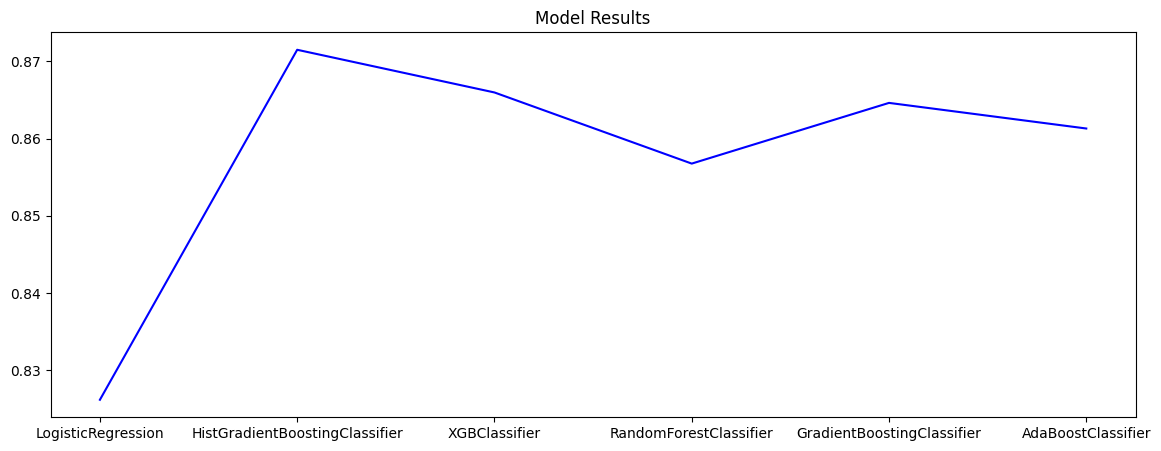

In [7]:
models = [LogisticRegression(), HistGradientBoostingClassifier(), XGBClassifier(),
          RandomForestClassifier(), GradientBoostingClassifier(), AdaBoostClassifier()]
model_results = []
for model in models:
    train(X_train, y_train, X_test, y_test, model, model_results)
model_names = [str(x).split('(')[0] for x in models]
f = plt.figure()
f.set_figwidth(14)
f.set_figheight(5)
plt.title('Model Results')
plt.plot(model_names,model_results,'b')
print(model_results)



#### As seen above, the models who got the highest accuracy score are HistGradientBoost, XGBoost, RF, GBC and Ada boost. Since the logistic regression did pretty poorly, in the hyper parameters search below I'll only check the other models since I don't expect the LR to do any better than the other models. 

In [8]:

# HistGB hyper parameters
Hist_params = {
    "learning_rate"      : sp_randFloat(0.01, 0.9),
    "max_depth"          : sp_randInt(2, 20),
}
    # XGBoost hyper parameters
XGBoost_params = {
    "learning_rate"      : [0.05, 0.10 ,0.15 ,0.20 , 0.25, 0.30],
    "max_depth"          : [3, 4, 5, 6, 8, 10, 12, 15],
    "min_child_weight"   : [1, 3, 5, 7],
    "gamma"              : [0.0, 0.1, 0.2 , 0.3, 0.4],
    "colsample_bytree"   : [0.3, 0.4, 0.5, 0.7],
    "max_delta_step"     : [0, 1, 2, 3, 4, 5, 10, 15, 20],
    "booster"            : ['gbtree', 'gblinear', 'dart']
}
# RandomForest hyper parameters
RF_params = {
    'n_estimators': np.arange(100,900,300),
    'max_depth': np.arange(8,12),
    'criterion': ['gini', 'entropy', 'log_loss']
}

# GradientBoostClassifier hyper parameters
GBC_params = {
    'loss': ['log_loss', 'deviance', 'exponential'],
    'learning_rate': sp_randFloat(0.05, 0.2),
    'n_estimators' : sp_randInt(50, 1000),  
    'subsample'    : sp_randFloat(0, 1),
    'max_depth'    : sp_randInt(2, 10),
}
# Adaboost hyper parameters
Adaboost_params = {
    "learning_rate": sp_randFloat(0.01, 5),
    "n_estimators": sp_randInt(50, 1000)
    }



models = [HistGradientBoostingClassifier(),XGBClassifier(),RandomForestClassifier(), GradientBoostingClassifier(), 
          AdaBoostClassifier()]
params = [Hist_params,XGBoost_params,RF_params,GBC_params,Adaboost_params]

### Using RandomSearchCv to hopefully find some better hyper parameters for the dataset

In [9]:
best_accuracy = 0
each_model_best_res = []
best_model = ''
for i in range(len(models)):
    clf = RandomizedSearchCV(models[i],
                   param_distributions=params[i],
                   n_iter = 10,
                   scoring='accuracy',
                   verbose=10,
                   n_jobs=1,
                   cv = 5,)
    clf.fit(X, y)
    if clf.best_score_ > best_accuracy:
        best_accuracy = clf.best_score_
        best_model = clf.best_estimator_
    each_model_best_res.append(clf.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START learning_rate=0.202993401768045, max_depth=7...............
[CV 1/5; 1/10] END learning_rate=0.202993401768045, max_depth=7;, score=0.870 total time=   0.5s
[CV 2/5; 1/10] START learning_rate=0.202993401768045, max_depth=7...............
[CV 2/5; 1/10] END learning_rate=0.202993401768045, max_depth=7;, score=0.872 total time=   0.7s
[CV 3/5; 1/10] START learning_rate=0.202993401768045, max_depth=7...............
[CV 3/5; 1/10] END learning_rate=0.202993401768045, max_depth=7;, score=0.867 total time=   0.7s
[CV 4/5; 1/10] START learning_rate=0.202993401768045, max_depth=7...............
[CV 4/5; 1/10] END learning_rate=0.202993401768045, max_depth=7;, score=0.872 total time=   0.5s
[CV 5/5; 1/10] START learning_rate=0.202993401768045, max_depth=7...............
[CV 5/5; 1/10] END learning_rate=0.202993401768045, max_depth=7;, score=0.870 total time=   0.4s
[CV 1/5; 2/10] START learning_rate=0.070486853701

[CV 1/5; 10/10] END learning_rate=0.1874133312239372, max_depth=16;, score=0.870 total time=   0.7s
[CV 2/5; 10/10] START learning_rate=0.1874133312239372, max_depth=16............
[CV 2/5; 10/10] END learning_rate=0.1874133312239372, max_depth=16;, score=0.870 total time=   0.5s
[CV 3/5; 10/10] START learning_rate=0.1874133312239372, max_depth=16............
[CV 3/5; 10/10] END learning_rate=0.1874133312239372, max_depth=16;, score=0.864 total time=   0.5s
[CV 4/5; 10/10] START learning_rate=0.1874133312239372, max_depth=16............
[CV 4/5; 10/10] END learning_rate=0.1874133312239372, max_depth=16;, score=0.874 total time=   0.6s
[CV 5/5; 10/10] START learning_rate=0.1874133312239372, max_depth=16............
[CV 5/5; 10/10] END learning_rate=0.1874133312239372, max_depth=16;, score=0.872 total time=   0.5s
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START booster=gbtree, colsample_bytree=0.3, gamma=0.1, learning_rate=0.15, max_delta_step=0, max_dep

[CV 5/5; 5/10] END booster=gbtree, colsample_bytree=0.4, gamma=0.2, learning_rate=0.1, max_delta_step=3, max_depth=12, min_child_weight=5;, score=0.871 total time=   1.4s
[CV 1/5; 6/10] START booster=gblinear, colsample_bytree=0.3, gamma=0.3, learning_rate=0.2, max_delta_step=3, max_depth=15, min_child_weight=7
[16:16:45] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "colsample_bytree", "gamma", "max_delta_step", "max_depth", "min_child_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV 1/5; 6/10] END booster=gblinear, colsample_bytree=0.3, gamma=0.3, learning_rate=0.2, max_delta_step=3, max_depth=15, min_child_weight=7;, score=0.813 total time=   0.1s
[CV 2/5; 6/10] START booster=

[CV 1/5; 8/10] END booster=gblinear, colsample_bytree=0.7, gamma=0.1, learning_rate=0.05, max_delta_step=4, max_depth=3, min_child_weight=1;, score=0.806 total time=   0.1s
[CV 2/5; 8/10] START booster=gblinear, colsample_bytree=0.7, gamma=0.1, learning_rate=0.05, max_delta_step=4, max_depth=3, min_child_weight=1
[16:16:47] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "colsample_bytree", "gamma", "max_delta_step", "max_depth", "min_child_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV 2/5; 8/10] END booster=gblinear, colsample_bytree=0.7, gamma=0.1, learning_rate=0.05, max_delta_step=4, max_depth=3, min_child_weight=1;, score=0.805 total time=   0.1s
[CV 3/5; 8/10] START booste

[CV 5/5; 10/10] END booster=gblinear, colsample_bytree=0.3, gamma=0.1, learning_rate=0.3, max_delta_step=0, max_depth=5, min_child_weight=1;, score=0.811 total time=   0.1s
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START criterion=gini, max_depth=9, n_estimators=400..............
[CV 1/5; 1/10] END criterion=gini, max_depth=9, n_estimators=400;, score=0.856 total time=   4.2s
[CV 2/5; 1/10] START criterion=gini, max_depth=9, n_estimators=400..............
[CV 2/5; 1/10] END criterion=gini, max_depth=9, n_estimators=400;, score=0.860 total time=   3.7s
[CV 3/5; 1/10] START criterion=gini, max_depth=9, n_estimators=400..............
[CV 3/5; 1/10] END criterion=gini, max_depth=9, n_estimators=400;, score=0.854 total time=   3.5s
[CV 4/5; 1/10] START criterion=gini, max_depth=9, n_estimators=400..............
[CV 4/5; 1/10] END criterion=gini, max_depth=9, n_estimators=400;, score=0.853 total time=   3.6s
[CV 5/5; 1/10] START criterion=gini, max_depth=9, 

[CV 5/5; 9/10] END criterion=entropy, max_depth=11, n_estimators=700;, score=0.860 total time=  11.1s
[CV 1/5; 10/10] START criterion=gini, max_depth=8, n_estimators=100.............
[CV 1/5; 10/10] END criterion=gini, max_depth=8, n_estimators=100;, score=0.858 total time=   1.2s
[CV 2/5; 10/10] START criterion=gini, max_depth=8, n_estimators=100.............
[CV 2/5; 10/10] END criterion=gini, max_depth=8, n_estimators=100;, score=0.860 total time=   1.1s
[CV 3/5; 10/10] START criterion=gini, max_depth=8, n_estimators=100.............
[CV 3/5; 10/10] END criterion=gini, max_depth=8, n_estimators=100;, score=0.853 total time=   1.1s
[CV 4/5; 10/10] START criterion=gini, max_depth=8, n_estimators=100.............
[CV 4/5; 10/10] END criterion=gini, max_depth=8, n_estimators=100;, score=0.852 total time=   1.1s
[CV 5/5; 10/10] START criterion=gini, max_depth=8, n_estimators=100.............
[CV 5/5; 10/10] END criterion=gini, max_depth=8, n_estimators=100;, score=0.860 total time=   1.0

[CV 5/5; 5/10] END learning_rate=0.10109584128754048, loss=log_loss, max_depth=9, n_estimators=210, subsample=0.7582191704891068;, score=0.866 total time=   9.6s
[CV 1/5; 6/10] START learning_rate=0.14056689216187435, loss=deviance, max_depth=7, n_estimators=479, subsample=0.23126373506199271
[CV 1/5; 6/10] END learning_rate=0.14056689216187435, loss=deviance, max_depth=7, n_estimators=479, subsample=0.23126373506199271;, score=0.836 total time=   6.6s
[CV 2/5; 6/10] START learning_rate=0.14056689216187435, loss=deviance, max_depth=7, n_estimators=479, subsample=0.23126373506199271
[CV 2/5; 6/10] END learning_rate=0.14056689216187435, loss=deviance, max_depth=7, n_estimators=479, subsample=0.23126373506199271;, score=0.848 total time=   6.3s
[CV 3/5; 6/10] START learning_rate=0.14056689216187435, loss=deviance, max_depth=7, n_estimators=479, subsample=0.23126373506199271
[CV 3/5; 6/10] END learning_rate=0.14056689216187435, loss=deviance, max_depth=7, n_estimators=479, subsample=0.2312

[CV 4/5; 1/10] END learning_rate=3.0799180893905387, n_estimators=90;, score=0.241 total time=   0.4s
[CV 5/5; 1/10] START learning_rate=3.0799180893905387, n_estimators=90..........
[CV 5/5; 1/10] END learning_rate=3.0799180893905387, n_estimators=90;, score=0.241 total time=   0.4s
[CV 1/5; 2/10] START learning_rate=1.8272517152195489, n_estimators=954.........
[CV 1/5; 2/10] END learning_rate=1.8272517152195489, n_estimators=954;, score=0.866 total time=  10.6s
[CV 2/5; 2/10] START learning_rate=1.8272517152195489, n_estimators=954.........
[CV 2/5; 2/10] END learning_rate=1.8272517152195489, n_estimators=954;, score=0.871 total time=  10.5s
[CV 3/5; 2/10] START learning_rate=1.8272517152195489, n_estimators=954.........
[CV 3/5; 2/10] END learning_rate=1.8272517152195489, n_estimators=954;, score=0.867 total time=  12.0s
[CV 4/5; 2/10] START learning_rate=1.8272517152195489, n_estimators=954.........
[CV 4/5; 2/10] END learning_rate=1.8272517152195489, n_estimators=954;, score=0.87

[CV 4/5; 10/10] END learning_rate=3.92347703343973, n_estimators=441;, score=0.759 total time=   2.4s
[CV 5/5; 10/10] START learning_rate=3.92347703343973, n_estimators=441..........
[CV 5/5; 10/10] END learning_rate=3.92347703343973, n_estimators=441;, score=0.759 total time=   2.5s


The best model accross all models is XGBClassifier and his accuracy score is 0.8715806715806715
[0.8712530712530713, 0.8715806715806715, 0.8596642096642098, 0.8687141687141686, 0.8708026208026208]


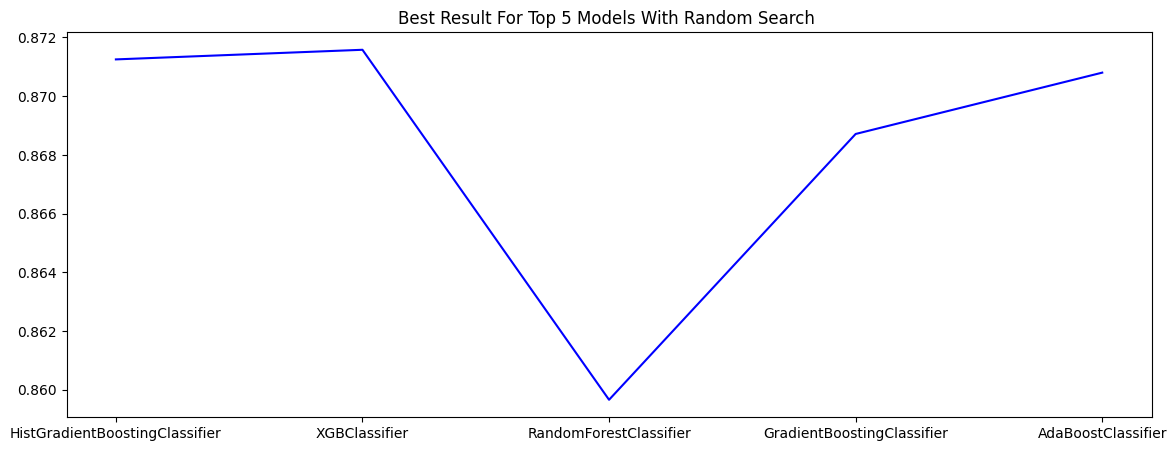

In [10]:
print(f'The best model accross all models is {str(best_model).split("(")[0]} and his accuracy score is {best_accuracy}')
model_names = [str(x).split('(')[0] for x in models]
f = plt.figure()
f.set_figwidth(14)
f.set_figheight(5)
plt.title('Best Result For Top 5 Models With Random Search ')
plt.plot(model_names, each_model_best_res,'b')
print(each_model_best_res)

### Summary
- After comparing all the different models, I chose the 5 that got the highest scores.
- After choosing the 5 best models, I started searching for the best hyper parameters for each model by using the randomized search cross validation.
- In the end, the model which got the highest accuracy score was the XGBoost with

   _learning_rate=0.3, max_depth=4, max_leaves=0, min_child_weight=3 and gamma=0.1_ as hyper parameters.

## <span style = "color:red">Note: </span>
- Although what was done until now was sufficient for the assignment, I wasn't quite happy with the result. I felt like the model could be much better, so I started checking on Google for better solutions both in running time and especially in the hyper parameter search method.
- After a short amount of time, I found the Bayesian Optimization for hyper parameter search and I'll implement it below using optuna.
- From now on, the code won't be part of the assignment. It will be an addition of mine for practicing, exploring and hopefully, getting some better results.
- In addition to that, since the Random Forest did pretty poorly in the random search above I'll omit it from the model list I'm checking to save running time. 

In [11]:
def objective(trial):
    classifier_name = trial.suggest_categorical("classifier", ["HistGBC","XGBoost",\
                                                              "GBC", "Adaboost" ])
    
    if classifier_name == "HistGBC":
        hist_lr = trial.suggest_float("hist_lr", 1e-10, 1e0, log=True)
        hist_max_depth = trial.suggest_int("hist_max_depth", 2,50)
        classifier_obj = HistGradientBoostingClassifier(learning_rate= hist_lr,
                                                       max_depth=hist_max_depth)
    elif classifier_name == "XGBoost":
        XGB_lr = trial.suggest_float("XGB_lr" ,1e-10, 1e0)
        XGB_max_depth = trial.suggest_int("XGB_max_depth",2, 32)
        XGB_min_child_weight = trial.suggest_int("XGB_min_child_weight",0.5,12)
        XGB_gamma = trial.suggest_float("XGB_gamma", 1e-10, 2e0)
        classifier_obj = XGBClassifier(learning_rate = XGB_lr,
                                      max_depth = XGB_max_depth,
                                      gamma= XGB_gamma,
                                      min_child_weight = XGB_min_child_weight)
        
        
    
    
    elif classifier_name == "RandomForest":
        rf_max_depth = trial.suggest_int("rf_max_depth", 8, 32, log = True)
        rf_estimator_number = trial.suggest_int("rf_estimator_number", 100, 1000, log = True)
        rf_criteria = trial.suggest_categorical("rf_criteria",['gini', 'entropy', 'log_loss'])
        classifier_obj = RandomForestClassifier(n_estimators=rf_estimator_number,
                                                max_depth=rf_max_depth,
                                                criterion = rf_criteria)
    
    
    elif classifier_name == "GBC":
        GBC_loss_func = trial.suggest_categorical("GBC_loss_func", ['log_loss', 'deviance', 'exponential'])
        GBC_lr = trial.suggest_float("GBC_lr", 1e-10, 1e0)
        GBC_n_estimators = trial.suggest_int("GBC_n_estimators", 50, 1000)
        GBC_sub_sample = trial.suggest_float("GBC_sub_sample", 2e-10,0.99) 
        GBC_max_depth = trial.suggest_int("GBC_max_depth",2, 32)
        classifier_obj = GradientBoostingClassifier(learning_rate=GBC_lr,
                                                   loss=GBC_loss_func,
                                                   n_estimators=GBC_n_estimators,
                                                   subsample=GBC_sub_sample,
                                                   max_depth=GBC_max_depth)
        
    elif classifier_name == "Adaboost":
        Ada_lr = trial.suggest_float("Ada_lr", 1e-10,1e0) 
        Ada_n_estimators = trial.suggest_int("Ada_n_estimators", 30,1000)
        classifier_obj = AdaBoostClassifier(learning_rate=Ada_lr,
                                           n_estimators=Ada_n_estimators)
    
    else:
        exit('Error: unknown classifier')
        
    score = sklearn.model_selection.cross_val_score(classifier_obj,X,y,n_jobs=1)
    accuracy= score.mean()
    return accuracy
    

In [12]:
study = optuna.create_study(direction="maximize")
study.optimize(objective,n_trials=50)

[I 2022-10-05 16:33:20,370] A new study created in memory with name: no-name-78bc7f59-fe94-4b35-8edf-b6891f67061e
[I 2022-10-05 16:35:47,819] Trial 0 finished with value: 0.8483619983619983 and parameters: {'classifier': 'GBC', 'GBC_loss_func': 'exponential', 'GBC_lr': 0.8078479942740286, 'GBC_n_estimators': 899, 'GBC_sub_sample': 0.908960910700016, 'GBC_max_depth': 6}. Best is trial 0 with value: 0.8483619983619983.
[I 2022-10-05 16:36:18,821] Trial 1 finished with value: 0.8592956592956593 and parameters: {'classifier': 'Adaboost', 'Ada_lr': 0.08904987068005309, 'Ada_n_estimators': 516}. Best is trial 1 with value: 0.8592956592956593.
[I 2022-10-05 16:36:30,715] Trial 2 finished with value: 0.8670761670761671 and parameters: {'classifier': 'Adaboost', 'Ada_lr': 0.7372976482864514, 'Ada_n_estimators': 213}. Best is trial 2 with value: 0.8670761670761671.
[I 2022-10-05 16:36:40,698] Trial 3 finished with value: 0.8695331695331696 and parameters: {'classifier': 'XGBoost', 'XGB_lr': 0.06

[I 2022-10-05 16:59:17,423] Trial 32 finished with value: 0.8699836199836198 and parameters: {'classifier': 'Adaboost', 'Ada_lr': 0.9929833711295077, 'Ada_n_estimators': 900}. Best is trial 20 with value: 0.8719492219492221.
[I 2022-10-05 16:59:55,490] Trial 33 finished with value: 0.8703931203931206 and parameters: {'classifier': 'Adaboost', 'Ada_lr': 0.8786171969137871, 'Ada_n_estimators': 675}. Best is trial 20 with value: 0.8719492219492221.
[I 2022-10-05 17:00:46,389] Trial 34 finished with value: 0.8712940212940212 and parameters: {'classifier': 'Adaboost', 'Ada_lr': 0.8842112818811387, 'Ada_n_estimators': 900}. Best is trial 20 with value: 0.8719492219492221.
[I 2022-10-05 17:00:48,294] Trial 35 finished with value: 0.8565929565929566 and parameters: {'classifier': 'Adaboost', 'Ada_lr': 0.8356114138567896, 'Ada_n_estimators': 33}. Best is trial 20 with value: 0.8719492219492221.
[I 2022-10-05 17:01:38,859] Trial 36 finished with value: 0.868959868959869 and parameters: {'classif

In [13]:
print('The best model found and the best hyper parameters'\
      f' using the Bayesian Optimization is {str(study.best_params)[14:].split(",")}'\
      f' with accuracy score of {study.best_value}' )

The best model found and the best hyper parameters using the Bayesian Optimization is [" 'HistGBC'", " 'hist_lr': 0.09816381586885223", " 'hist_max_depth': 48}"] with accuracy score of 0.8719492219492221


### [Bayesian optimization using optuna conclusions](#section-title)

As seen above even the bayesian optimization did not improve the models accuracy, at least not as much as I expected. I started to look for some article in the subject: does different hyperparameters can really change the accuracy score significantly?. After a long search I found this articl: __[Article Link](https://arxiv.org/pdf/2207.06028.pdf)__

 which by coincidence is an article of my proffesor (this one got me a little exited). In the article we can see that in most of the cases the hyperparameter search, whether its done by optuna or by random search will not affect by much the accuracy score, although the Adaboost model may improve more than the others which is exactly what I got here! 